Aluno: Gabriel Freitas Santos
MEC 2014

In [1]:
import pandas as pd
import scipy.io as sio
import numpy as np
from os import getcwd,pardir
from os.path import join ,abspath
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.tsa import ar_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
from scipy.stats.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, RepeatedKFold,
RandomizedSearchCV)
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
import warnings
warnings.filterwarnings('ignore')

c:\Program Files\Python38\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\Gabriel Freitas\AppData\Local\Temp\ipykernel_24760\4274094508.py:16: DeprecationWarning: Please use `mode` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import mode


0 - Desenvolvimento do Modelo AR do trabalho anterior

In [2]:
fname = join(abspath(join(getcwd(), pardir))+'\\02_feature','data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar
FeatAR = []
na=30 #Model Order
for i in range(Nc):
    ARmodel2 = ar_model.AutoReg(Ch2[:,i],na).fit()
    ARmodel3 = ar_model.AutoReg(Ch3[:,i],na).fit()
    ARmodel4 = ar_model.AutoReg(Ch4[:,i],na).fit()
    ARmodel5 = ar_model.AutoReg(Ch5[:,i],na).fit()
    ARparams = np.concatenate([ARmodel2.params,ARmodel3.params,ARmodel4.params,ARmodel5.params])
    FeatAR.append(ARparams)
FeatAR=np.array(FeatAR)
FeatAR.shape # X1
ln,cols = FeatAR.shape
#Montar PCA
pca = PCA(n_components=4)
mdAR_PCA = pca.fit_transform(FeatAR)
dfAR_PCA = pd.concat([pd.DataFrame(mdAR_PCA),pd.DataFrame({'target':y})],axis=1)
train_x, test_x, train_y, test_y = train_test_split(dfAR_PCA[dfAR_PCA.columns[0:-1]], dfAR_PCA.target, test_size=0.3, random_state=0)

1 - Aplicação do algoritmo k-means e plot dos resultados.

Utilizado o método de pairplot que permite a visualização gráfica da intereção de todas as features.


Text(0.5, 0.98, 'Dataset Classificado por KMeans')

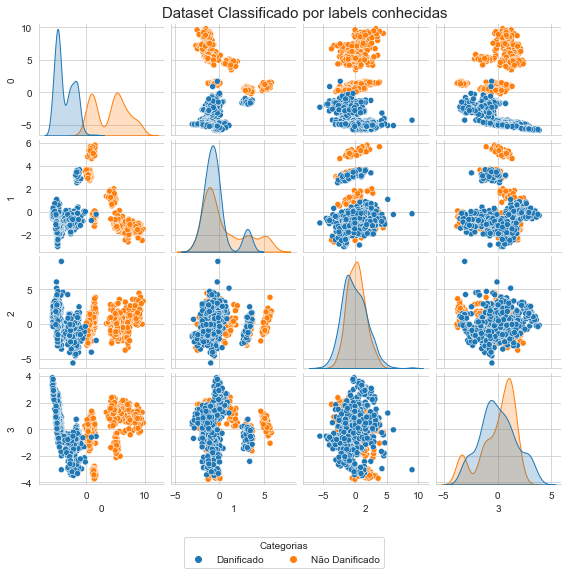

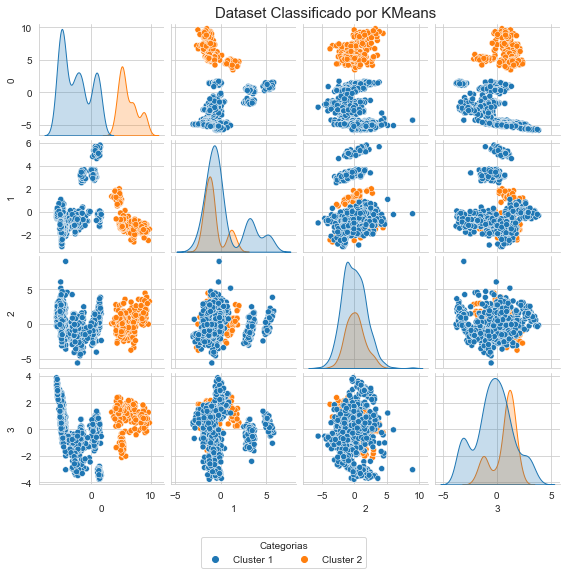

In [3]:
#Testas KMeans para todas as classes conhecidads (2 Tipos, Danificado e Não Danificado)
kmeans = KMeans(n_clusters=2, random_state=0).fit(dfAR_PCA[dfAR_PCA.columns[0:-1]])
dfAR_PCA_plot = pd.concat([dfAR_PCA,pd.DataFrame({'clusters_kmeans':kmeans.labels_})],axis=1)
dfAR_PCA_plot['target'][dfAR_PCA['target'] < 9] = 1
dfAR_PCA_plot['target'][dfAR_PCA['target'] >=9] = 0
print('Utilizado o método de pairplot que permite a visualização gráfica da intereção de todas as features.')
fig1 =sns.pairplot(dfAR_PCA_plot[dfAR_PCA_plot.columns[dfAR_PCA_plot.columns!='clusters_kmeans']],hue='target',height=2)
fig1._legend.remove()
handles = fig1._legend_data.values()
labels = ['Danificado','Não Danificado']
fig1.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig1.fig.subplots_adjust(top=0.95, bottom=0.15)
fig1.fig.suptitle('Dataset Classificado por labels conhecidas',fontsize=15)
fig2=sns.pairplot(dfAR_PCA_plot[dfAR_PCA_plot.columns[dfAR_PCA_plot.columns!='target']],hue='clusters_kmeans',height=2)
fig2._legend.remove()
handles = fig2._legend_data.values()
labels = ['Cluster 1', 'Cluster 2']
fig2.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig2.fig.subplots_adjust(top=0.95, bottom=0.15)
fig2.fig.suptitle('Dataset Classificado por KMeans',fontsize=15)


O Cluster 1 possui 75.0% das suas amostras com o tipo "Danificado" e o Cluster 2 possui 100.0% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:


[Text(0, 0.5, 'Danificado'), Text(0, 1.5, 'Não Danificado')]

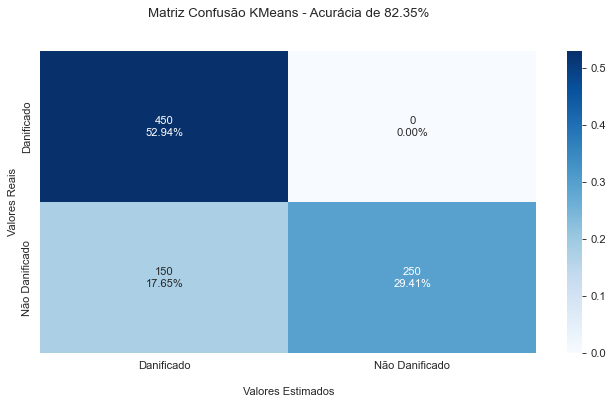

In [4]:
cl1per = dfAR_PCA_plot['clusters_kmeans'][(dfAR_PCA_plot['clusters_kmeans']==0) & (dfAR_PCA_plot['target']==0)].count()/dfAR_PCA_plot['clusters_kmeans'][dfAR_PCA_plot['clusters_kmeans']==0].count()
cl2per =dfAR_PCA_plot['clusters_kmeans'][(dfAR_PCA_plot['clusters_kmeans']==1) & (dfAR_PCA_plot['target']==1)].count()/dfAR_PCA_plot['clusters_kmeans'][dfAR_PCA_plot['clusters_kmeans']==1].count()
acc = (dfAR_PCA_plot['clusters_kmeans'][(dfAR_PCA_plot['clusters_kmeans']==0) & (dfAR_PCA_plot['target']==0)].count() + dfAR_PCA_plot['clusters_kmeans'][(dfAR_PCA_plot['clusters_kmeans']==1) & (dfAR_PCA_plot['target']==1)].count())
acc=acc/dfAR_PCA_plot['clusters_kmeans'].count()
print(f'O Cluster 1 possui {round(100*cl1per,2)}% das suas amostras com o tipo "Danificado" e o Cluster 2 possui {round(100*cl2per,2)}% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:')
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts_x1 = ["{0:0.0f}".format(value) for value in
                confusion_matrix(dfAR_PCA_plot['target'], dfAR_PCA_plot['clusters_kmeans']).flatten()]            

group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     confusion_matrix(dfAR_PCA_plot['target'], dfAR_PCA_plot['clusters_kmeans']).flatten()/np.sum(confusion_matrix(dfAR_PCA_plot['target'], dfAR_PCA_plot['clusters_kmeans']))]                 

labels_x1 = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
       

labels_x1 = np.asarray(labels_x1).reshape(2,2)
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
ax1 = sns.heatmap(confusion_matrix(dfAR_PCA_plot['target'], dfAR_PCA_plot['clusters_kmeans'])/len(dfAR_PCA_plot['target']),annot=labels_x1,  cmap='Blues', fmt='')
ax1.set_title(f'Matriz Confusão KMeans - Acurácia de {round(100*acc,2)}%\n\n')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')

## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(['Danificado','Não Danificado'])
ax1.yaxis.set_ticklabels(['Danificado','Não Danificado'])


Apesar da taxa relativamente alta de falsos positivos, o modelo é aceitavel pois não houve nenhum falso negativo.

2 - Visualizar dados usando T-SNE

Text(0.5, 0.98, 'Dataset transformado por T-SNE e classificado pelo Label conhecido')

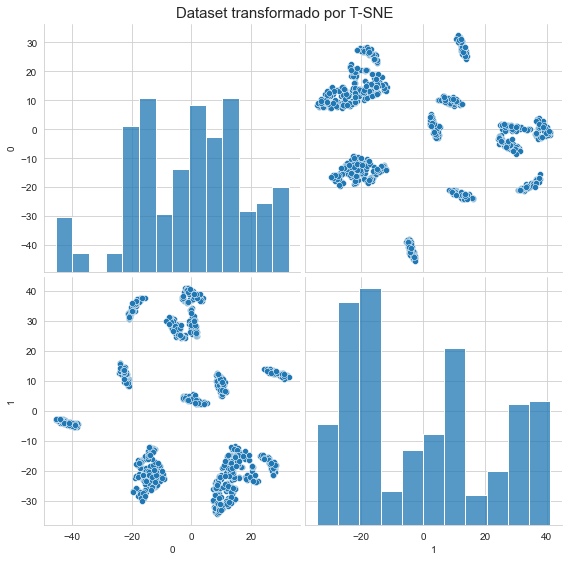

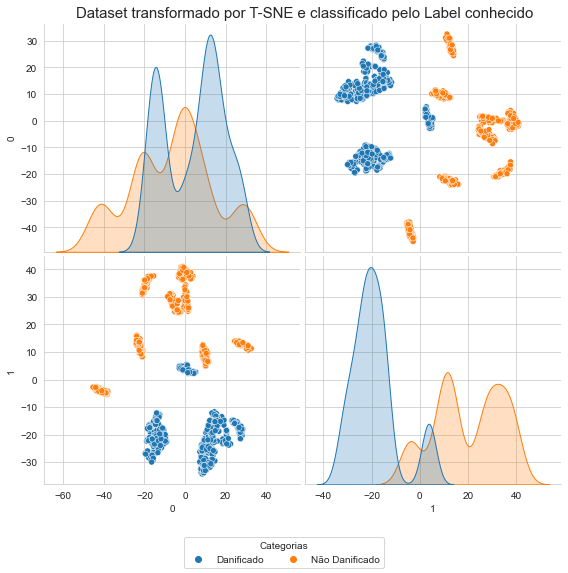

In [5]:
dfAR_TSNE = pd.DataFrame(TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(dfAR_PCA[dfAR_PCA.columns[0:-1]]))
fig3=sns.pairplot(dfAR_TSNE,height=4)
fig3.fig.subplots_adjust(top=0.95, bottom=0.08)
fig3.fig.suptitle('Dataset transformado por T-SNE',fontsize=15)
dfAR_TSNE = pd.concat([dfAR_TSNE,dfAR_PCA_plot['target']],axis=1)
fig4=sns.pairplot(dfAR_TSNE,hue='target',height=4)
fig4._legend.remove()
handles = fig4._legend_data.values()
labels = ['Danificado', 'Não Danificado']
fig4.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig4.fig.subplots_adjust(top=0.95, bottom=0.15)
fig4.fig.suptitle('Dataset transformado por T-SNE e classificado pelo Label conhecido',fontsize=15)



Se Aplicarmos a metodologica de classificação por KMeans aos dados transformados por T-SNE

Text(0.5, 0.98, 'Dataset Classificado por KMeans')

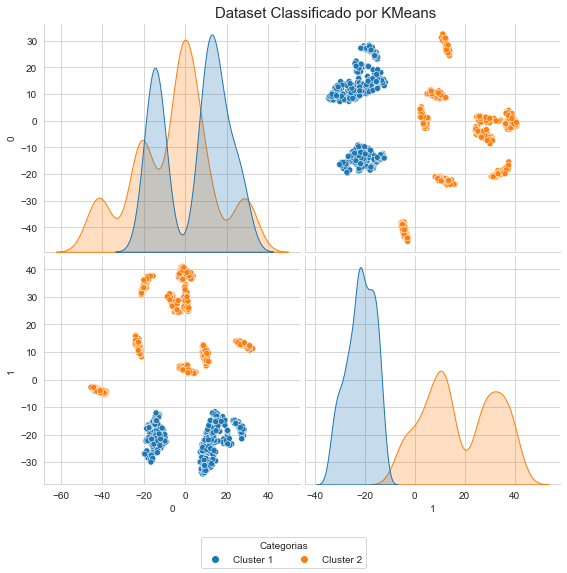

In [6]:
#Testas KMeans para todas as classes conhecidads (2 Tipos, Danificado e Não Danificado)
kmeans = KMeans(n_clusters=2, random_state=0).fit(dfAR_TSNE[dfAR_TSNE.columns[0:-1]])
dfAR_TSNE_plot = pd.concat([dfAR_TSNE,pd.DataFrame({'clusters_kmeans':kmeans.labels_})],axis=1)
# temp=dfAR_TSNE_plot['clusters_kmeans'].copy()
# temp[dfAR_TSNE_plot['clusters_kmeans']==0]=1
# temp[dfAR_TSNE_plot['clusters_kmeans']==1]=0
# dfAR_TSNE_plot['clusters_kmeans']=temp.copy()
fig5=sns.pairplot(dfAR_TSNE_plot[dfAR_TSNE_plot.columns[dfAR_TSNE_plot.columns!='target']],hue='clusters_kmeans',height=4)
fig5._legend.remove()
handles = fig5._legend_data.values()
labels = ['Cluster 1', 'Cluster 2']
fig5.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig5.fig.subplots_adjust(top=0.95, bottom=0.15)
fig5.fig.suptitle('Dataset Classificado por KMeans',fontsize=15)

O Cluster 1 possui 100.0% das suas amostras com o tipo "Danificado" e o Cluster 2 possui 88.89% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:


[Text(0, 0.5, 'Danificado'), Text(0, 1.5, 'Não Danificado')]

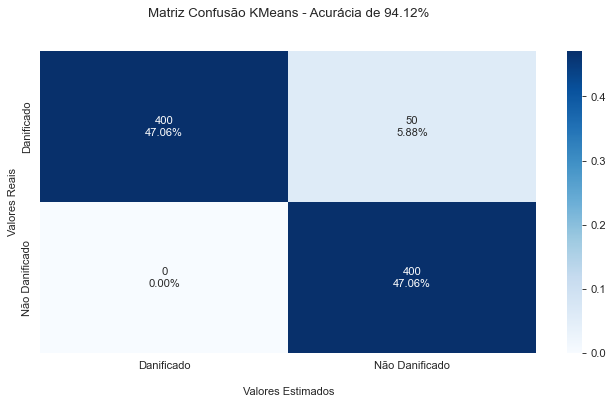

In [7]:
#Matriz de confusão
cl1perTSNE = dfAR_TSNE_plot['clusters_kmeans'][(dfAR_TSNE_plot['clusters_kmeans']==0) & (dfAR_TSNE_plot['target']==0)].count()/dfAR_TSNE_plot['clusters_kmeans'][dfAR_TSNE_plot['clusters_kmeans']==0].count()
cl2perTSNE =dfAR_TSNE_plot['clusters_kmeans'][(dfAR_TSNE_plot['clusters_kmeans']==1) & (dfAR_TSNE_plot['target']==1)].count()/dfAR_TSNE_plot['clusters_kmeans'][dfAR_TSNE_plot['clusters_kmeans']==1].count()
acc = (dfAR_TSNE_plot['clusters_kmeans'][(dfAR_TSNE_plot['clusters_kmeans']==0) & (dfAR_TSNE_plot['target']==0)].count() + dfAR_TSNE_plot['clusters_kmeans'][(dfAR_TSNE_plot['clusters_kmeans']==1) & (dfAR_PCA_plot['target']==1)].count())
acc=acc/dfAR_TSNE_plot['clusters_kmeans'].count()
print(f'O Cluster 1 possui {round(100*cl1perTSNE,2)}% das suas amostras com o tipo "Danificado" e o Cluster 2 possui {round(100*cl2perTSNE,2)}% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:')
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts_x1 = ["{0:0.0f}".format(value) for value in
                confusion_matrix(dfAR_TSNE_plot['target'], dfAR_TSNE_plot['clusters_kmeans']).flatten()]            

group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     confusion_matrix(dfAR_TSNE_plot['target'], dfAR_TSNE_plot['clusters_kmeans']).flatten()/np.sum(confusion_matrix(dfAR_TSNE_plot['target'], dfAR_TSNE_plot['clusters_kmeans']))]                 

labels_x1 = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
       

labels_x1 = np.asarray(labels_x1).reshape(2,2)
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
ax2 = sns.heatmap(confusion_matrix(dfAR_TSNE_plot['target'], dfAR_TSNE_plot['clusters_kmeans'])/len(dfAR_TSNE_plot['target']),annot=labels_x1,  cmap='Blues', fmt='')
ax2.set_title(f'Matriz Confusão KMeans - Acurácia de {round(100*acc,2)}%\n\n')
ax2.set_xlabel('\nValores Estimados')
ax2.set_ylabel('Valores Reais')

## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(['Danificado','Não Danificado'])
ax2.yaxis.set_ticklabels(['Danificado','Não Danificado'])

Apesar do aumento da acurácia global do classificador, nesta situação temos um aumento significativo de falsos negativos. Tornando o modelo menos confiavel para casos criticos.

Text(0.5, 0.98, 'Dataset Classificado por OneClassSVM')

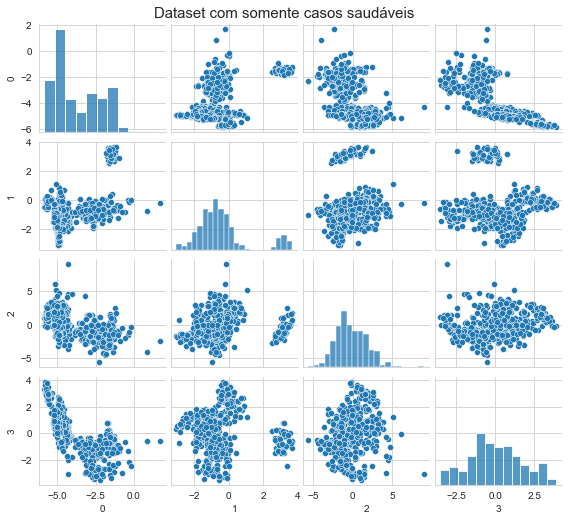

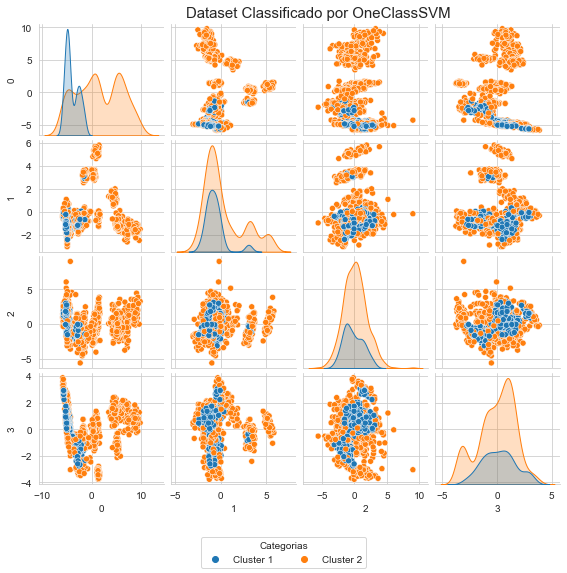

In [48]:
OCSVM = OneClassSVM(gamma='auto').fit(dfAR_PCA[dfAR_PCA_plot['target']==0].iloc[:,0:-1]) #Treinamento somente com dados saudaveis
dfAR_OCSVM = pd.concat([dfAR_PCA, pd.DataFrame({'clusters_SVM':OCSVM.predict(dfAR_PCA.iloc[:,0:-1])})],axis=1)
dfAR_OCSVM['clusters_SVM'][dfAR_OCSVM['clusters_SVM']==1]=0
dfAR_OCSVM['clusters_SVM'][dfAR_OCSVM['clusters_SVM']==-1]=1
dfAR_OCSVM['target'] = dfAR_TSNE_plot['target']

fig6=sns.pairplot(dfAR_PCA[dfAR_PCA_plot['target']==0].iloc[:,0:-1],height=2)
fig6.fig.subplots_adjust(top=0.95, bottom=0.15)
fig6.fig.suptitle('Dataset com somente casos saudáveis',fontsize=15)

fig7=sns.pairplot(dfAR_OCSVM[dfAR_OCSVM.columns[dfAR_OCSVM.columns!='target']],hue='clusters_SVM',height=2)
fig7._legend.remove()
handles = fig7._legend_data.values()
labels = ['Cluster 1', 'Cluster 2']
fig7.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig7.fig.subplots_adjust(top=0.95, bottom=0.15)
fig7.fig.suptitle('Dataset Classificado por OneClassSVM',fontsize=15)

O Cluster 1 possui 63.9% das suas amostras com o tipo "Danificado" e o Cluster 2 possui 100.0% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:


[Text(0, 0.5, 'Danificado'), Text(0, 1.5, 'Não Danificado')]

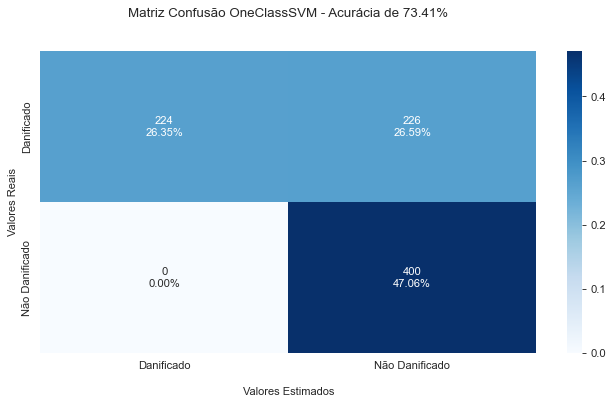

In [53]:
#Matriz de confusão
cl1perOSVM = dfAR_OCSVM['clusters_SVM'][(dfAR_OCSVM['clusters_SVM']==1) & (dfAR_OCSVM['target']==1)].count()/dfAR_OCSVM['clusters_SVM'][dfAR_OCSVM['clusters_SVM']==1].count()
cl2perOSVM =dfAR_OCSVM['clusters_SVM'][(dfAR_OCSVM['clusters_SVM']==0) & (dfAR_OCSVM['target']==0)].count()/dfAR_OCSVM['clusters_SVM'][dfAR_OCSVM['clusters_SVM']==0].count()
acc = (dfAR_OCSVM['clusters_SVM'][(dfAR_OCSVM['clusters_SVM']==0) & (dfAR_OCSVM['target']==0)].count() + dfAR_OCSVM['clusters_SVM'][(dfAR_OCSVM['clusters_SVM']==1) & (dfAR_OCSVM['target']==1)].count())
acc=acc/dfAR_OCSVM['clusters_SVM'].count()
print(f'O Cluster 1 possui {round(100*cl1perOSVM,2)}% das suas amostras com o tipo "Danificado" e o Cluster 2 possui {round(100*cl2perOSVM,2)}% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:')
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts_x1 = ["{0:0.0f}".format(value) for value in
                confusion_matrix(dfAR_OCSVM['target'], dfAR_OCSVM['clusters_SVM']).flatten()]            

group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     confusion_matrix(dfAR_OCSVM['target'], dfAR_OCSVM['clusters_SVM']).flatten()/np.sum(confusion_matrix(dfAR_OCSVM['target'], dfAR_OCSVM['clusters_SVM']))]                 

labels_x1 = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
       

labels_x1 = np.asarray(labels_x1).reshape(2,2)
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
ax2 = sns.heatmap(confusion_matrix(dfAR_OCSVM['target'], dfAR_OCSVM['clusters_SVM'])/len(dfAR_OCSVM['target']),annot=labels_x1,  cmap='Blues', fmt='')
ax2.set_title(f'Matriz Confusão OneClassSVM - Acurácia de {round(100*acc,2)}%\n\n')
ax2.set_xlabel('\nValores Estimados')
ax2.set_ylabel('Valores Reais')

## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(['Danificado','Não Danificado'])
ax2.yaxis.set_ticklabels(['Danificado','Não Danificado'])

O algoritmo de OneClass SVM não foi capaz de identificar com qualidade os outliers do dataset utilizando a saida do PCA como feature. Será feita mais uma tentativa utilizando T-SNE após o PCA.

Text(0.5, 0.98, 'Dataset Classificado por OneClassSVM')

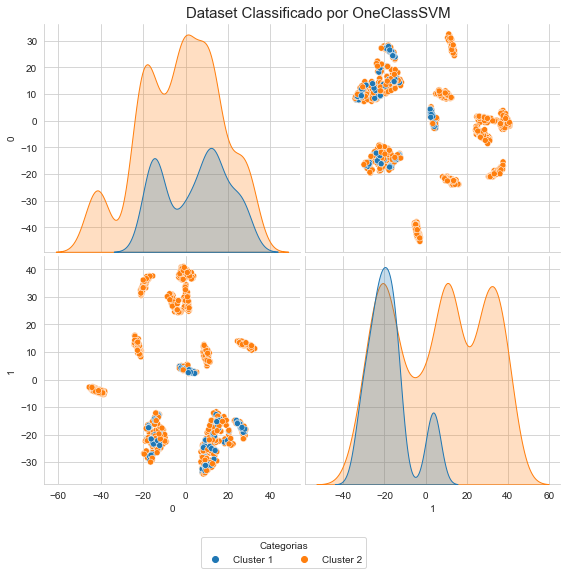

In [57]:
OCSVM_TS= OneClassSVM(gamma='auto').fit(dfAR_TSNE[dfAR_TSNE['target']==0].iloc[:,0:-1]) #Treinamento somente com dados saudaveis
dfAR_OCSVM_TS = pd.concat([dfAR_TSNE, pd.DataFrame({'clusters_SVM':OCSVM_TS.predict(dfAR_TSNE.iloc[:,0:-1])})],axis=1)
dfAR_OCSVM_TS['clusters_SVM'][dfAR_OCSVM_TS['clusters_SVM']==1]=0
dfAR_OCSVM_TS['clusters_SVM'][dfAR_OCSVM_TS['clusters_SVM']==-1]=1
dfAR_OCSVM_TS['target'] = dfAR_TSNE_plot['target']
fig7=sns.pairplot(dfAR_OCSVM_TS[dfAR_OCSVM_TS.columns[dfAR_OCSVM_TS.columns!='target']],hue='clusters_SVM',height=4)
fig7._legend.remove()
handles = fig7._legend_data.values()
labels = ['Cluster 1', 'Cluster 2']
fig7.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3,title='Categorias')
fig7.fig.subplots_adjust(top=0.95, bottom=0.15)
fig7.fig.suptitle('Dataset Classificado por OneClassSVM',fontsize=15)

O Cluster 1 possui 64.1% das suas amostras com o tipo "Danificado" e o Cluster 2 possui 100.0% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:


[Text(0, 0.5, 'Danificado'), Text(0, 1.5, 'Não Danificado')]

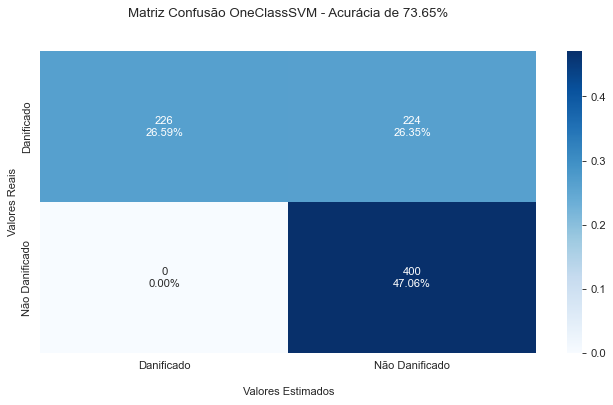

In [58]:
#Matriz de confusão
cl1perOSVM_TS = dfAR_OCSVM_TS['clusters_SVM'][(dfAR_OCSVM_TS['clusters_SVM']==1) & (dfAR_OCSVM_TS['target']==1)].count()/dfAR_OCSVM_TS['clusters_SVM'][dfAR_OCSVM_TS['clusters_SVM']==1].count()
cl2perOSVM_TS =dfAR_OCSVM_TS['clusters_SVM'][(dfAR_OCSVM_TS['clusters_SVM']==0) & (dfAR_OCSVM_TS['target']==0)].count()/dfAR_OCSVM_TS['clusters_SVM'][dfAR_OCSVM_TS['clusters_SVM']==0].count()
acc = (dfAR_OCSVM_TS['clusters_SVM'][(dfAR_OCSVM_TS['clusters_SVM']==0) & (dfAR_OCSVM_TS['target']==0)].count() + dfAR_OCSVM_TS['clusters_SVM'][(dfAR_OCSVM_TS['clusters_SVM']==1) & (dfAR_OCSVM_TS['target']==1)].count())
acc=acc/dfAR_OCSVM_TS['clusters_SVM'].count()
print(f'O Cluster 1 possui {round(100*cl1perOSVM_TS,2)}% das suas amostras com o tipo "Danificado" e o Cluster 2 possui {round(100*cl2perOSVM_TS,2)}% das suas amostras com o tipo "Não Danificado". Abaixo a matriz de confusão da predição:')
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts_x1 = ["{0:0.0f}".format(value) for value in
                confusion_matrix(dfAR_OCSVM_TS['target'], dfAR_OCSVM_TS['clusters_SVM']).flatten()]            

group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     confusion_matrix(dfAR_OCSVM_TS['target'], dfAR_OCSVM_TS['clusters_SVM']).flatten()/np.sum(confusion_matrix(dfAR_OCSVM_TS['target'], dfAR_OCSVM_TS['clusters_SVM']))]                 

labels_x1 = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
       

labels_x1 = np.asarray(labels_x1).reshape(2,2)
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
ax2 = sns.heatmap(confusion_matrix(dfAR_OCSVM_TS['target'], dfAR_OCSVM_TS['clusters_SVM'])/len(dfAR_OCSVM_TS['target']),annot=labels_x1,  cmap='Blues', fmt='')
ax2.set_title(f'Matriz Confusão OneClassSVM - Acurácia de {round(100*acc,2)}%\n\n')
ax2.set_xlabel('\nValores Estimados')
ax2.set_ylabel('Valores Reais')

## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(['Danificado','Não Danificado'])
ax2.yaxis.set_ticklabels(['Danificado','Não Danificado'])

Ao contrário do método de kmeans, o metódo de OneClassSVM, proporciona uma alto numero de falsos positivos, estretanto, uma há uma confiabilidade maior por não ter falsos negativos. Para aplicações onde falsos negativos não são aceitaveis, esta pode ser uma aplicação apesar da acurácia mais baixa.